In [113]:
import networkx as nx
from numpy  import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from scipy.stats import pareto, lognorm
import matplotlib.colors as mcolors
import pandas as pd

n = 300


# Set plot style
sns.set(style='whitegrid')


In [114]:
def analyze_network(G, name):
    degrees = [d for n, d in G.degree()]
    avg_degree = np.mean(degrees)
    clustering_coeffs = nx.clustering(G).values()
    avg_clustering = np.mean(list(clustering_coeffs))
    shortest_path_length = dict(nx.shortest_path_length(G))
    avg_path_length = np.mean([l for target_dict in shortest_path_length.values() for l in target_dict.values()])

    print(f"Analysis of {name}:")
    print(f"- Number of nodes: {G.number_of_nodes()}")
    print(f"- Number of edges: {G.number_of_edges()}")
    print(f"- Average degree: {avg_degree:.2f}")
    print(f"- Average clustering coefficient: {avg_clustering:.4f}")
    print(f"- Average shortest path length: {avg_path_length:.2f}")

    # Degree distribution plot
    plt.figure(figsize=(8, 6))
    sns.histplot(degrees, bins=range(max(degrees)+1), kde=False)
    plt.title(f'Degree Distribution of {name}')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()


### Let's generate different samples of complex networks to test our model and see how each of them behave


## 1- Barabasi-Albert model (Scale-free Networks)
Few nodes have high degree (many connections), while most nodes have few connections. Uses preferential attachment, meaning that new nodes have higher probability of attaching to existing nodes with higher degree. 
- Power law degree distribution: small number of highly connected hubs
- Heterogeneous structure: nodes with a vastly different number of connections
- Robustness: resistant to random failures but vulnerable to attacks on central nodes -> this is what we are gonna analyze here.

### Parameters:
1) n: the number of nodes
2) the number of edges a new node will create when added to the network. These edges are preferrably attached to existing nodes based on their current degree.

As an example, this one could be suitable to model the growth of social networks where a few people have many connections.

In [115]:
m = 2  # Number of edges to attach from a new node to existing nodes

barabasi_graph = nx.barabasi_albert_graph(n, m)
barabasi_graph = barabasi_graph.to_directed()

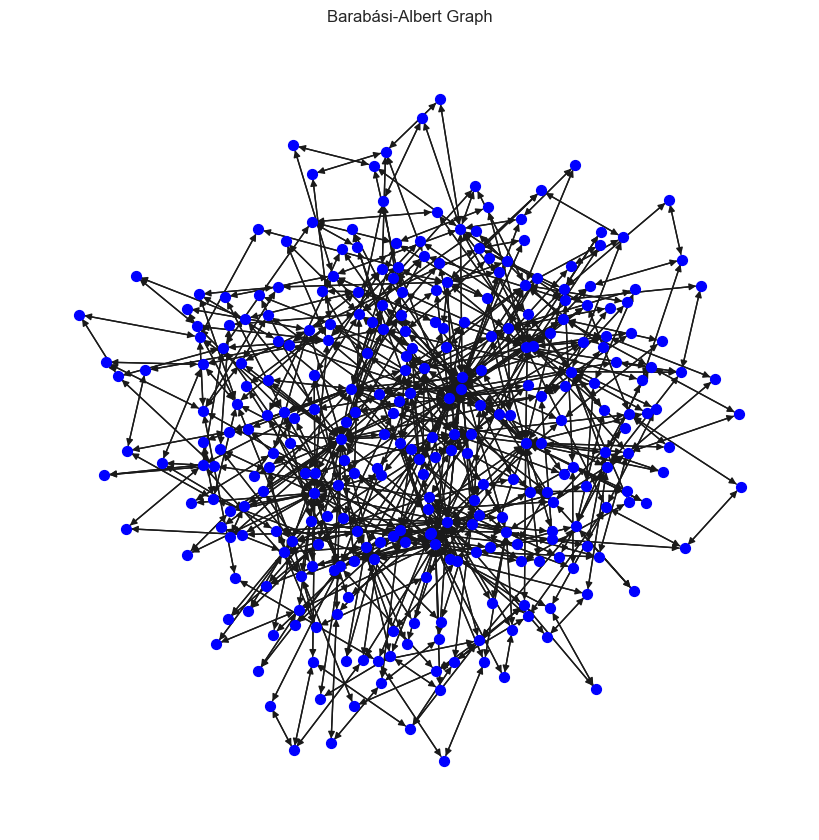

In [116]:
plt.figure(figsize=(8, 8))  # Set the figure size for better visibility
nx.draw(barabasi_graph, node_size=50, node_color="blue", with_labels=False)
plt.title("Barabási-Albert Graph")
plt.show()

Analysis of Barabási-albert model:
- Number of nodes: 300
- Number of edges: 1192
- Average degree: 7.95
- Average clustering coefficient: 0.0616
- Average shortest path length: 3.65


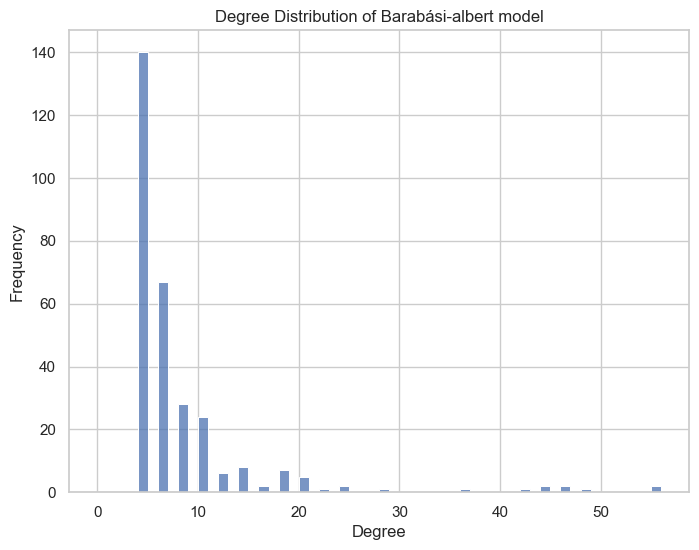

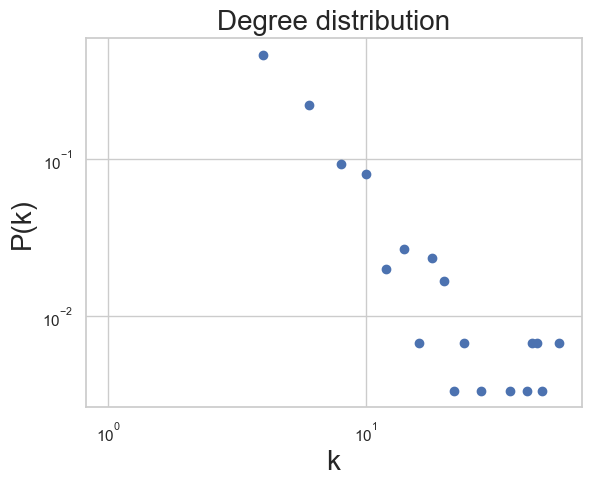

In [117]:
analyze_network(barabasi_graph, 'Barabási-albert model')

def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values()) # we get only the degree values
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

ks, Pk = degree_distribution(barabasi_graph)

plt.figure()
plt.loglog(ks,Pk,'bo',base=10)
plt.xlabel("k", fontsize=20)
plt.ylabel("P(k)", fontsize=20)
plt.title("Degree distribution", fontsize=20)
plt.grid(True)
plt.savefig('degree_dist.eps') #save the figure into a file
plt.show(True)


In [118]:
M = np.column_stack((ks,Pk))
np.savetxt('BA_distribution.txt', M, delimiter='\t')

## Small World Network
- Local clustering. Nodes tend to be connected to their neighbors. 
- Short average path lenght: There is a few of "hops" or connections betwen two nodes in the graph. The p parameter defines the probability of rewire.

### Parameters:
1) Number of Nodes (n): total number of nodes/vertices. This might represent people, computers, neurons etc.
2) Nearest neighbors (k): each node is connected to k nearest neighbors. If 𝑘 = 2, each node connects to its two immediate neighbors on both sides (like a circular lattice). Controls the local clustering of the network.
3) Rewiring probability (p): controls the degree of randomness in the network. For each edge in the initial lattice, it is randomly rewired with probability p.
- When p=0, the network is a regular lattice with high clustering and long path lengths.
- When p=1, the network is fully random, with low clustering but short path lengths.
- When 0<p<1, the network becomes a Small-World, where you retain some clustering while reducing the path length.


In [119]:
# Parameters
k = 4   # each node is connected to k nearest neighbors in ring topology
p = 0.5  # probability of rewiring each edge

# Create an undirected Small-World network
G_undirected = nx.watts_strogatz_graph(n, k, p)

# Convert it to a directed graph by creating directed edges from the undirected graph
G_directed = nx.DiGraph()
G_directed.add_edges_from((u, v) for u, v in G_undirected.edges())
G_directed.add_edges_from((v, u) for u, v in G_undirected.edges())
SW_graph = G_directed

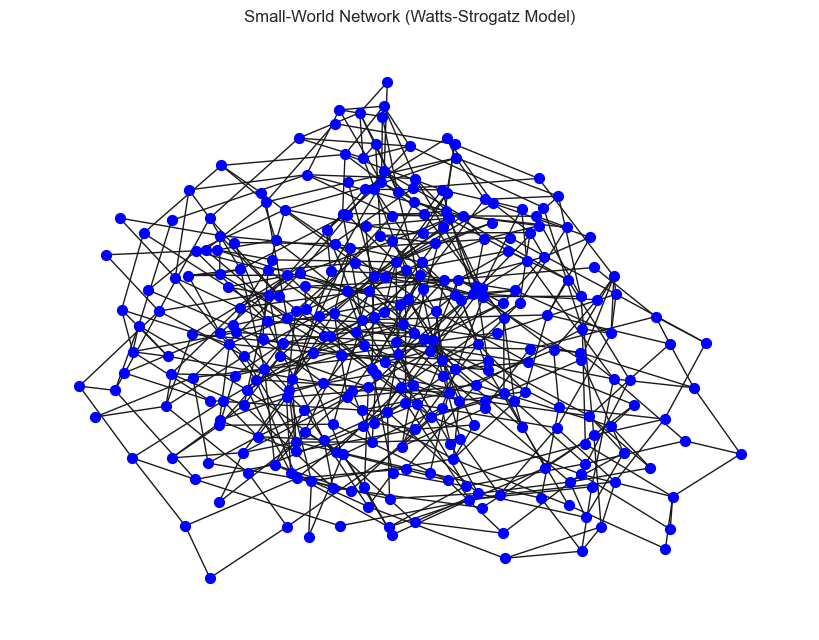

In [120]:

# Draw the network
plt.figure(figsize=(8, 6))
nx.draw(G_undirected, node_size=50, node_color='blue', with_labels=False)
plt.title("Small-World Network (Watts-Strogatz Model)")
plt.show()

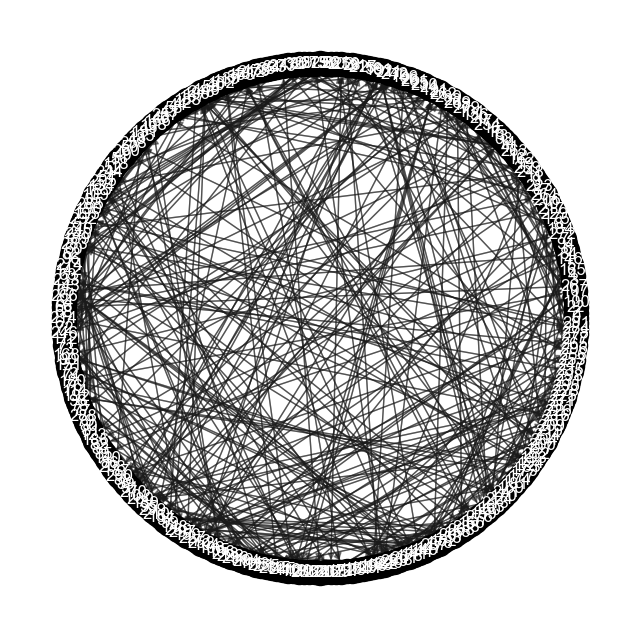

In [121]:
pos = nx.circular_layout(SW_graph)
plt.figure(figsize=(8,8))
plt.axis("off")
nx.draw_networkx_nodes(SW_graph, pos, node_size=300, node_color="black")
nx.draw_networkx_edges(SW_graph, pos, alpha=0.500)
nx.draw_networkx_labels(SW_graph, pos, font_color="white")
plt.show()

Analysis of Small-world Network:
- Number of nodes: 300
- Number of edges: 1200
- Average degree: 8.00
- Average clustering coefficient: 0.0826
- Average shortest path length: 4.56


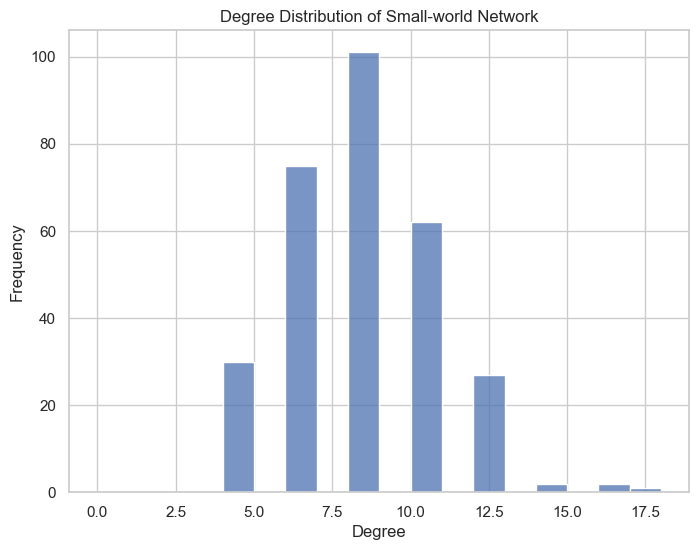

In [122]:
analyze_network(SW_graph, 'Small-world Network')

## Random Graph Network - Erdős–Rényi (ER) model

- This graph is composed by N nodes and each connection between pairs of nodes are stablished according to probability p. This is a typical case of a Bernoulli process.




In [123]:

p = 0.05  # Probability of edge creation between any two nodes
ER_graph = nx.gnp_random_graph(n, p, seed=None)

# Convert it to a bidirectional directed graph
ER_graph = ER_graph.to_directed()

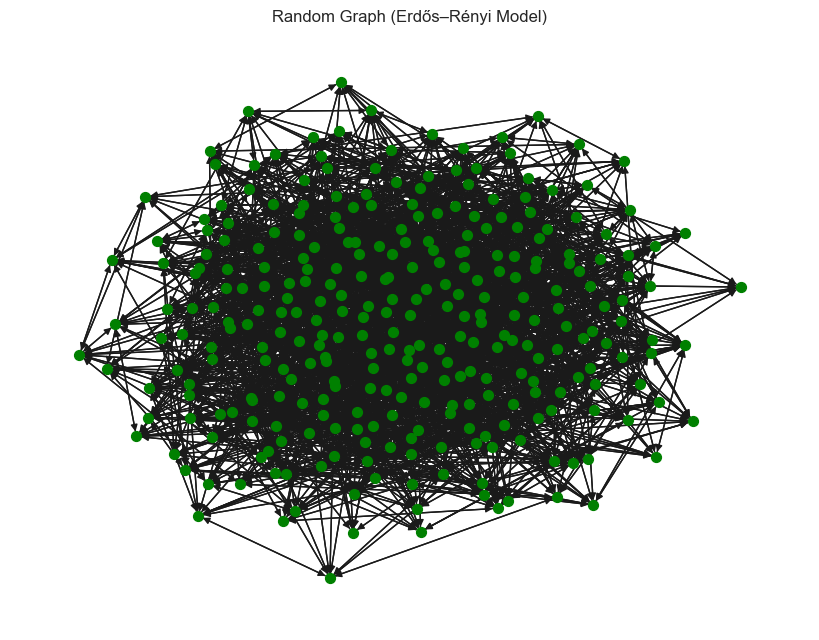

In [124]:

# Draw the network
plt.figure(figsize=(8, 6))
nx.draw(ER_graph, node_size=50, node_color='green', with_labels=False)
plt.title("Random Graph (Erdős–Rényi Model)")
plt.show()


In [125]:
def degree_distribution(GER):
    vk = dict(GER.degree())
    vk = list(vk.values()) # we get only the degree values
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

In [126]:
ks, Pk = degree_distribution(ER_graph)

Analysis of Random Graph:
- Number of nodes: 300
- Number of edges: 4538
- Average degree: 30.25
- Average clustering coefficient: 0.0510
- Average shortest path length: 2.38


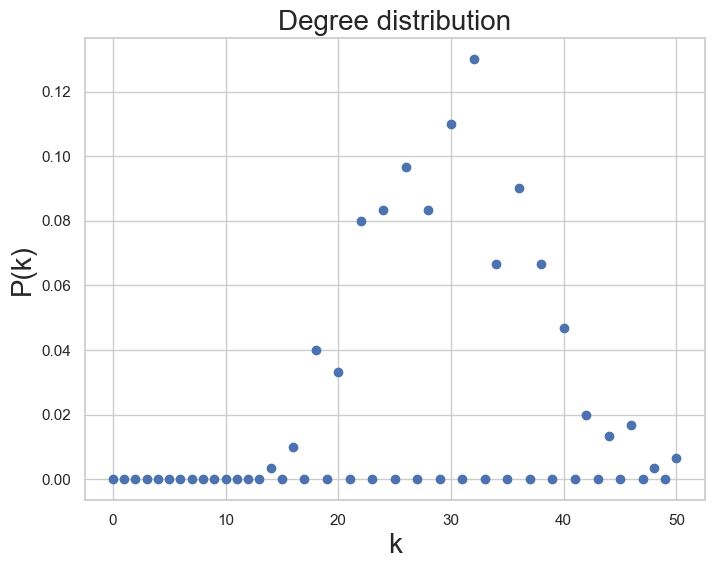

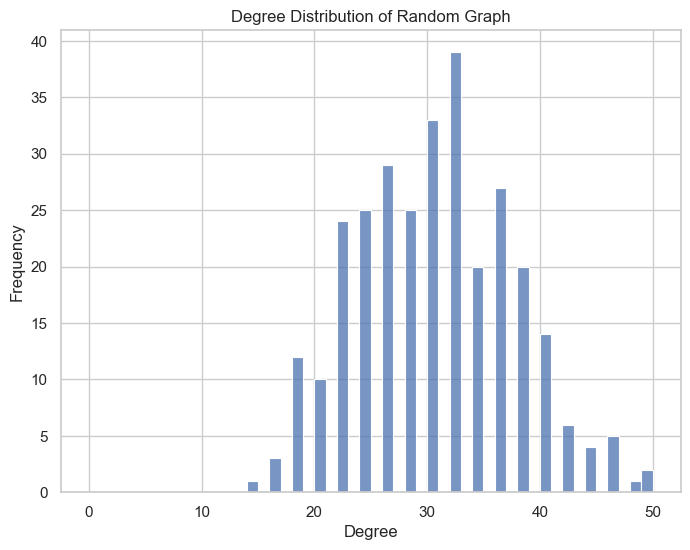

In [127]:
plt.figure(figsize=(8,6))
plt.plot(ks,Pk,'bo', label='Data')
plt.xlabel("k", fontsize=20)
plt.ylabel("P(k)", fontsize=20)
plt.title("Degree distribution", fontsize=20)
plt.grid(True)
#plt.savefig('degree_dist.eps') #save the figure into a file


analyze_network(ER_graph, 'Random Graph')

## Modelo de Waxman
- n: O número de nós no grafo. Cada nó representa uma entidade conectada na rede.
- alpha: Controla a densidade de arestas no grafo. Valores maiores de alpha aumentam a probabilidade de haver uma aresta entre nós, independentemente da distância.
- beta: Controla como a distância influencia a probabilidade de haver uma aresta entre nós. Valores maiores de beta tornam as conexões mais prováveis, mesmo a longas distâncias. Valores menores fazem com que a probabilidade decaia mais rapidamente com a distância.

- Baseada em distâncias: A conectividade depende da proximidade dos nós no espaço.
- Controle de densidade e alcance: Os parâmetros a e b permitem controlar a densidade geral da rede e a probabilidade de conexões entre nós distantes.
- Modelo probabilístico: O modelo Waxman é estocástico, o que significa que a estrutura da rede mudará a cada execução, mesmo com os mesmos parâmetros.


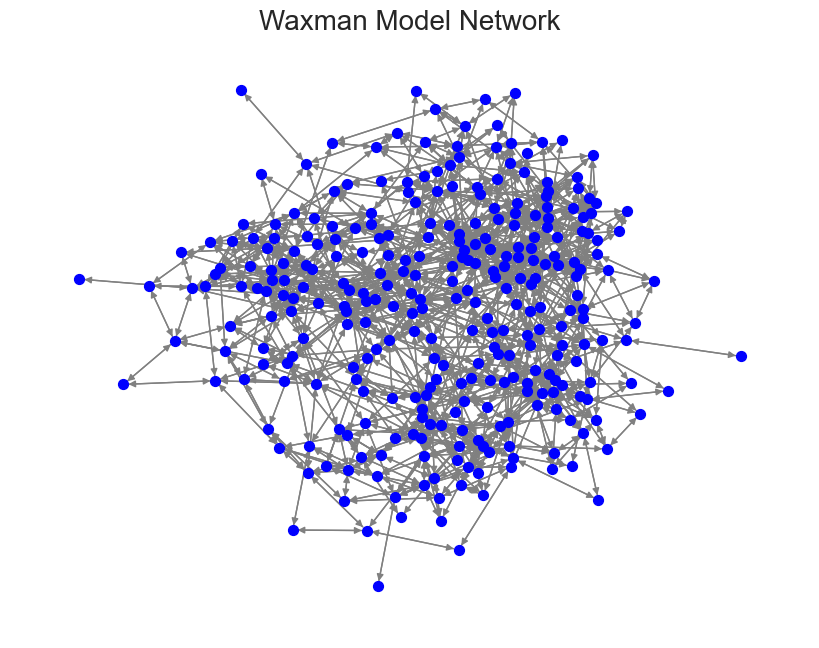

In [128]:


# Parâmetros para o modelo de Waxman
alpha = 0.1  # Parâmetro que controla a densidade de arestas
beta = 0.3   # Parâmetro que controla a decaída da probabilidade com a distância

G_undirected = nx.waxman_graph(n, alpha=alpha, beta=beta, domain=(0, 0, 1, 1))

# Convert to a directed graph
G_directed = nx.DiGraph()
G_directed.add_edges_from((u, v) for u, v in G_undirected.edges())
G_directed.add_edges_from((v, u) for u, v in G_undirected.edges())
WM_graph = G_directed

# Desenhar a rede
plt.figure(figsize=(8, 6))
nx.draw(WM_graph, node_size=50, node_color='blue', with_labels=False, edge_color='gray')
plt.title("Waxman Model Network",fontsize=20)
plt.show()

Analysis of Waxman Network:
- Number of nodes: 300
- Number of edges: 1954
- Average degree: 13.03
- Average clustering coefficient: 0.0587
- Average shortest path length: 3.51


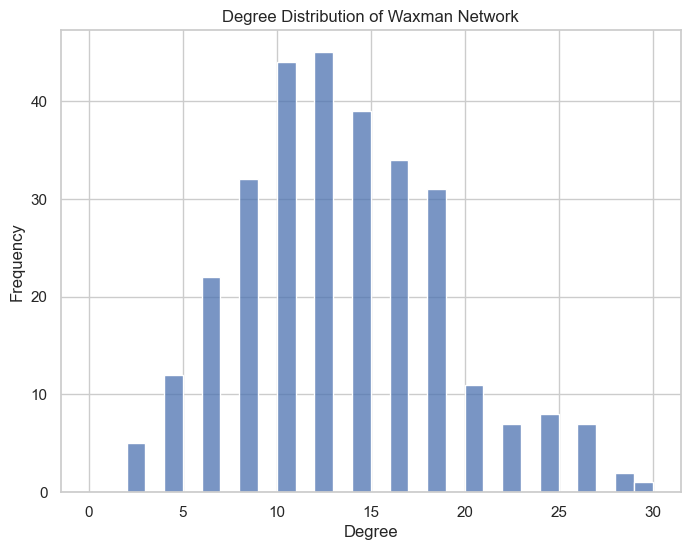

In [129]:
analyze_network(WM_graph, 'Waxman Network')

## Assigning values for nodes and edges

We will assign values for the nodes and the edges of the graphs, using uniform and exponential distributions, both with average $\mu$.

In [130]:

def assign_node_total_assets(G, mean_assets, distribution='lognormal'):
    n = G.number_of_nodes()
    if distribution == 'lognormal':
        sigma = 1.0  # Adjust as needed
        mu = np.log(mean_assets) - (sigma ** 2) / 2
        assets_values = np.random.lognormal(mu, sigma, n)
    else:
        raise ValueError("Unsupported distribution type.")
    assets_dict = {node: assets for node, assets in zip(G.nodes(), assets_values)}
    nx.set_node_attributes(G, assets_dict, 'total_assets')
    return G

def assign_node_equity(G, capital_ratio=0.1):
    for node in G.nodes():
        A_i = G.nodes[node]['total_assets']
        E_i = capital_ratio * A_i
        G.nodes[node]['cap_buffer'] = E_i
    return G

def assign_edge_investments(G, interbank_asset_fraction=0.2):
    for node in G.nodes():
        A_i = G.nodes[node]['total_assets']
        interbank_assets = interbank_asset_fraction * A_i
        out_edges = list(G.out_edges(node))
        num_out_edges = len(out_edges)
        if num_out_edges == 0:
            continue
        # Generate random weights that sum to 1
        weights = np.random.dirichlet(np.ones(num_out_edges))
        investments = interbank_assets * weights
        for idx, (u, v) in enumerate(out_edges):
            G.edges[u, v]['investment'] = investments[idx]
    return G


def assign_node_equities(G, mean_equity, distribution='uniform'):
    n = G.number_of_nodes()
    if distribution == 'uniform':
        equity_values = np.random.uniform(0, 2 * mean_equity, n)
    elif distribution == 'exponential':
        equity_values = np.random.exponential(mean_equity, n)
    else:
        raise ValueError("Unsupported distribution type.")
    equity_dict = {node: cap_buffer for node, cap_buffer in zip(G.nodes(), equity_values)}
    nx.set_node_attributes(G, equity_dict, 'cap_buffer')
    return G

# Function to assign investments to edges
def assign_edges_investments(G, mean_investment, distribution='uniform'):
    for node in G.nodes():
        equity_i = G.nodes[node]['cap_buffer']
        out_edges = list(G.out_edges(node))
        num_out_edges = len(out_edges)
        if num_out_edges == 0:
            continue
        # Generate potential investments for each outgoing edge
        if distribution == 'uniform':
            investments = np.random.uniform(0, 2 * mean_investment, num_out_edges)
        elif distribution == 'exponential':
            investments = np.random.exponential(mean_investment, num_out_edges)
        else:
            raise ValueError("Unsupported distribution type.")

        adjusted_investments = investments.tolist()
        #total_investment = sum(adjusted_investments)

        # Assign investments to edges
        for idx, (u, v) in enumerate(out_edges):
            G.edges[u, v]['investment'] = adjusted_investments[idx]
    return G

# Function to calculate the relative economic value of node j in comparison to the entire network
def calculate_relative_values(G):
    # Calculate total investments made by all nodes
    total_network_investment = sum([G.edges[u, v]['investment'] for u, v in G.edges()])
    # Calculate investments made by each node
    node_investments = {}
    for node in G.nodes():
        out_edges = list(G.out_edges(node))
        total_investment = sum([G.edges[u, v]['investment'] for u, v in out_edges])
        node_investments[node] = total_investment
    # Calculate v_j for each node
    node_values = {}
    for node in G.nodes():
        A_j = node_investments.get(node, 0)
        v_j = A_j / total_network_investment if total_network_investment > 0 else 0
        node_values[node] = v_j
        # Optionally, store v_j as a node attribute
        G.nodes[node]['v_j'] = v_j
    return G


# Function to draw the graph
def draw_graph(G, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    # Node sizes based on cap_buffer
    node_sizes = [G.nodes[node]['cap_buffer'] * 1.5 for node in G.nodes()]
    # Edge widths based on investment
    edge_widths = [G.edges[edge].get('investment', 0.01) * 0.01 for edge in G.edges()]
    # Node colors based on v_j
    v_j_values = [G.nodes[node].get('v_j', 0) for node in G.nodes()]
    cmap = plt.cm.viridis
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=v_j_values, cmap=cmap)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=edge_widths, arrows=True, arrowstyle='->', arrowsize=15)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(v_j_values), vmax=max(v_j_values)))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('v_j Value')
    plt.title(title)
    plt.axis('off')
    plt.show()



In [131]:
mu_equity = 300
mu_investment = 100
distribution = 'uniform'

mean_assets = 1e9  # Mean total assets
capital_ratio = 0.1  # 10% capital ratio
interbank_asset_fraction = 0.4  # 20% of assets are interbank assets



graphs = {
    'erdos_renyi': ER_graph,
    'barabasi_albert': barabasi_graph,
    'small_world': SW_graph,
    'waxman': WM_graph
}


for name, G in graphs.items():
    G = assign_node_total_assets(G, mean_assets=mean_assets)
    G = assign_node_equities(G, mean_equity=mu_equity, distribution=distribution)
    G = assign_edges_investments(G, mean_investment=mu_investment, distribution=distribution)
    G = calculate_relative_values(G)
    graphs[name] = G 




In [132]:
#draw_graph(graphs['barabasi_albert'], 'Barabasi-albert')
#draw_graph(graphs['waxman'], 'Waxman')
#draw_graph(graphs['erdos_renyi'], 'Erdos-Renyi')
#draw_graph(graphs['small_world'], 'Small-world')

In [133]:
def create_adjacency_matrix(G):
    """
    Creates an adjacency matrix representing the investments between nodes.

    Parameters:
    - G: NetworkX graph object.

    Returns:
    - adjacency_matrix: pandas DataFrame representing the adjacency matrix.
    """
    nodes = sorted(G.nodes())
    adjacency_matrix = pd.DataFrame(0.0, index=nodes, columns=nodes)
    for u, v in G.edges():
        investment = G.edges[u, v].get('investment', 0.0)
        adjacency_matrix.loc[u, v] = investment
    return adjacency_matrix


def create_node_table(G):
    """
    Creates a table with columns ['node', 'cap_buffer', 'total_investments', 'v_j'] for each node.

    Parameters:
    - G: NetworkX graph object.

    Returns:
    - node_table: pandas DataFrame containing the node data.
    """
    node_data = []
    for node in G.nodes():
        cap_buffer = G.nodes[node]['cap_buffer']
        total_investments = sum([G.edges[u, v]['investment'] for u, v in G.out_edges(node)])
        v_j = G.nodes[node]['v_j']
        node_data.append({
            'node': node,
            'cap_buffer': cap_buffer,
            'total_investments': total_investments,
            'v_j': v_j
        })
    node_table = pd.DataFrame(node_data)
    return node_table



In [134]:
# Generate adjacency matrix for each graph
adj_matrix_er = create_adjacency_matrix(graphs['erdos_renyi'])
adj_matrix_ba = create_adjacency_matrix(graphs['barabasi_albert'])
adj_matrix_sw = create_adjacency_matrix(graphs['small_world'])
adj_matrix_wm = create_adjacency_matrix(graphs['waxman'])

# Generate node data table for each graph
node_table_er = create_node_table(graphs['erdos_renyi'])
node_table_ba = create_node_table(graphs['barabasi_albert'])
node_table_sw = create_node_table(graphs['small_world'])
node_table_wm = create_node_table(graphs['waxman'])

#adj_matrix_er.to_excel("adj_matrix.xlsx")




# DebtRank algorithm

Finally, we are going to implement the DebtRank algorithm. Before, we generated all the key components of the algorithm:
1- Capital Buffer $E_{i}$: the capital buffer of each node i, representing the node's ability to absorb losses.

2- Investment matrix $A_{ij}$: The weighted adjacency matrix representing investments from node $i$ to node $j$

3- Impact matrix $W_{ij}$: Defined as W_{ij} = min{1, \frac {A_{ij}{E_j}}}-> this one we are going to calculate now

We also have:
- State Variables:


### Steps:
- Compute impact matrix $W_{ij}$
- Implement algorithm
- Visualization

In [135]:
graphs.keys()

G = graphs["barabasi_albert"]
W = {}
for u, v in G.edges():
    A_ji = G.edges[v, u]['investment']  # Correct the investment direction
    E_j = G.nodes[v]['cap_buffer']
    W_ij = min(1, A_ji / E_j) if E_j > 0 else 1  # Avoid division by zero
    W[(u, v)] = W_ij

    print(A_ji, E_j, W_ij)

97.14693172329794 585.4531998510565 0.16593458153104776
54.862492935965875 15.357782822510902 1
87.7461542099028 504.40607821405996 0.17395935140310714
92.49616366555951 84.32240569194016 1
123.07182626854944 486.8863332334066 0.25277322008862074
35.7789304434438 94.44043266753765 0.37885182683774615
152.38298653262206 98.64429339227677 1
95.19021223379416 300.61096836000564 0.316655818492279
7.311997548825899 546.4323427949233 0.013381341066720313
97.13920992537606 200.28845438261163 0.48499655272096087
131.8484824508831 42.94493525320937 1
36.92928561625519 0.11834449432110983 1
149.58079830907394 410.74851111418457 0.3641663798204049
196.23258464766838 135.72244215575967 1
100.54247265428047 407.9357403544864 0.24646644730591996
188.70306482018185 360.5672025322259 0.5233506084162394
6.496950898510323 320.6366961005415 0.02026265545249096
89.03056108425264 420.93974614930573 0.21150428748696454
118.49681187244052 501.39119720421064 0.23633604365849722
21.42077469039425 599.821845475

In [136]:
def compute_impact_matrixx(G):
    W = {}
    for u, v in G.edges():
        A_ij = G.edges[u, v]['investment']
        E_j = G.nodes[v]['cap_buffer']
        W_ij = min(1, A_ij / E_j) if E_j > 0 else 1 ##avoid division by 0
        W[(u, v)] = W_ij
        G.edges[u, v]['W_ij'] = W_ij

    return W


def compute_impact_matrix(G):
    W = {}
    for u, v in G.edges():
        A_ji = G.edges[v, u]['investment']  # Correct the investment direction
        E_j = G.nodes[v]['cap_buffer']
        W_ij = min(1, A_ji / E_j) if E_j > 0 else 1  # Avoid division by zero
        W[(u, v)] = W_ij
        G.edges[u, v]['W_ij'] = W_ij

    return W


In [137]:
# We will shock the node with the githest degree in the network
def get_highest_degree_node(G):
    degree_dict = dict(G.degree())
    return max(degree_dict, key=degree_dict.get)

def debt_rank(G, S_f, y = 1.0):
    """
    Implementation of the DebtRank Algorithm
    
    params:
    -G: graph object with 'investment' on edges and 'cap_buffer' on nodes
    -S_f: list of initially distressed nodes
    -y: initial distress level (1.0 means default)


    Returns:
    - R: DebtRank value
    - h: dictionary of h_i values for each node (the los of each node)
    - s: disctionary of s_i states for each node over time
    """

    # Initialize variables
    h = {}  # Distress levels h_i(t)
    s = {}  # States s_i(t)
    T = 0   # Time steps

    #Initializing time 0. Every impact is 0, and also every node is unactive, except for the one(s) with the initial impact
    nodes = G.nodes()
    for i in nodes:
        h[i] = [0]  # Initialize h_i(1)
        if i in S_f:
            h[i][0] = y
            s_i = ['D']
        else:
            s_i = ['U']
        s[i] = s_i

    # Precompute W_ji for incoming edges to each node
    W_in = {}
    for i in nodes:
        W_in[i] = []
        for j in G.predecessors(i):
            W_ji = G.edges[j, i]['W_ij']
            W_in[i].append((j, W_ji)) #here we know all impacts that "arrive" in node i



    # Dynamics
    active = True
    while active:
        T += 1  # Increment time
        active = False  # Will be set to True if any node is still active

        # Update h_i(t) for all nodes
        h_t = {}
        for i in nodes:
            if s[i][-1] != 'I': #if it's not inactive now

                #calculations for h_i_t, as defined in the article
                #sum of impacts from all predecessors j that are distressed at t - 1
                sum_impact = sum([W_ji * h[j][T-1] for (j, W_ji) in W_in[i] if s[j][T-1] == 'D']) 
                h_i_t = min(1.0, h[i][T-1] + sum_impact)
                h_t[i] = h_i_t

                if h_i_t > h[i][T-1]: #if current impact is higher
                    active = True
            else:
                h_t[i] = h[i][T-1]

        # Update s_i(t) for all nodes
        s_t = {}
        for i in nodes:
            if s[i][-1] == 'D': # a node that goes in the D state, will move to the I state one step later
                s_t[i] = 'I'
            elif h_t[i] > 0 and s[i][-1] != 'I': #if a node was impactaded and is not inactive (then it's undistressed, cause there is no other option since we have the other if right before)
                s_t[i] = 'D'
                active = True
            else:
                s_t[i] = s[i][-1] #if it's inactive or there is no impact yet, the state remains the same

        # Append new values to h and s
        for i in nodes:
            h[i].append(h_t[i])
            s[i].append(s_t[i])

    # Calculate DebtRank R
    v = nx.get_node_attributes(G, 'v_j')
    R = sum([h[i][-1] * v[i] for i in nodes]) - sum([h[i][0] * v[i] for i in nodes])

    return R, h, s, T


    
    



In [138]:
y = 1.0

results = {}

for graph_name in graphs.keys():
    G = graphs[graph_name]
    # Compute impact matrix W_ij
    W = compute_impact_matrix(G)
    # Run DebtRank algorithm

debt_rank_results = []

for graph_name in graphs.keys():
    G = graphs[graph_name]
    nodes = G.nodes()
    v_j = nx.get_node_attributes(G, 'v_j')
    for node in nodes:
        # Run DebtRank algorithm with the current node as the distressed node
        S_f = [node]
        R, h, s, T = debt_rank(G, S_f, y=1.0)
        # Store the results in the list
        debt_rank_results.append({
            'graph': graph_name,
            'node': node,
            'DebtRank': R,
            'time_steps': T,
            'v_j': v_j[node],
            # Additional attributes can be added here
        })

In [139]:
df_debt_rank = pd.DataFrame(debt_rank_results)

In [140]:
df_debt_rank.to_excel("debt_rank.xlsx")

In [141]:
# Function to compute node attributes and add to the DataFrame
def add_node_attributes(df, G):
    # Compute centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    closeness_centrality = nx.closeness_centrality(G)
    # Add attributes to the DataFrame
    df['degree_centrality'] = df['node'].map(degree_centrality)
    df['betweenness_centrality'] = df['node'].map(betweenness_centrality)
    df['eigenvector_centrality'] = df['node'].map(eigenvector_centrality)
    df['closeness_centrality'] = df['node'].map(closeness_centrality)
    # Add equity
    equity = nx.get_node_attributes(G, 'cap_buffer')
    df['cap_buffer'] = df['node'].map(equity)
    return df

# Apply the function to each graph
df_list = []
for graph_name in graphs.keys():
    G = graphs[graph_name]
    df_graph = df_debt_rank[df_debt_rank['graph'] == graph_name].copy()
    df_graph = add_node_attributes(df_graph, G)
    df_list.append(df_graph)

# Concatenate the DataFrames
df_debt_rank = pd.concat(df_list, ignore_index=True)




### Now, we have the debtRank computed for each node in each different topology, independently of it's centrality. What we will do now is analyze if there is a positive correlation between the node size or the size of its investments or the node centrality and the impact this node has in the network

let's first plot the debtrank per node:

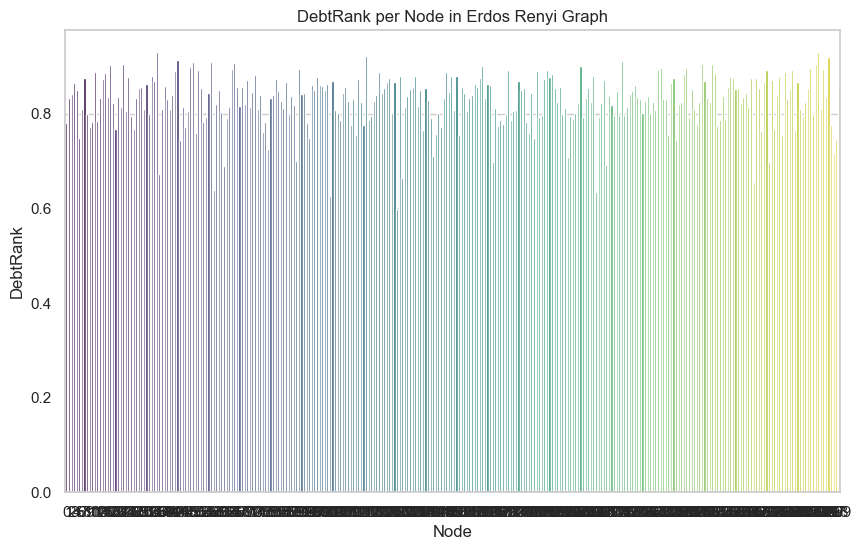

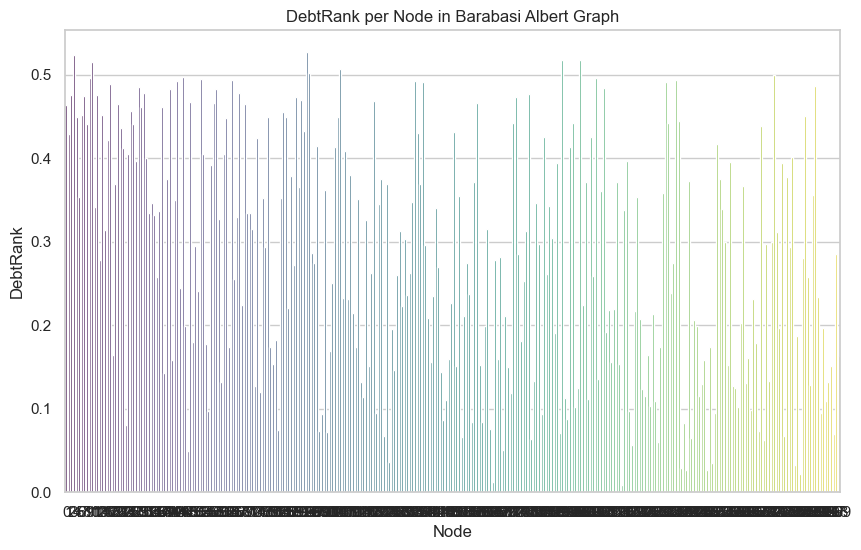

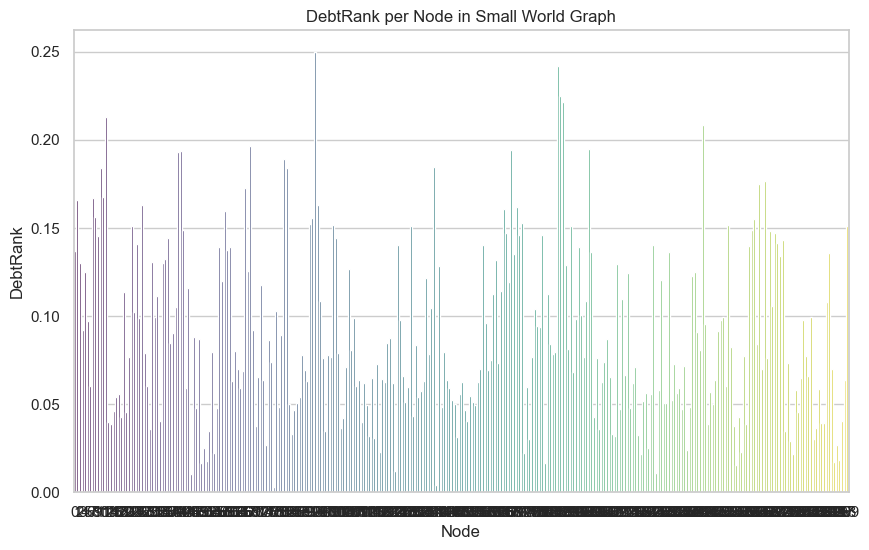

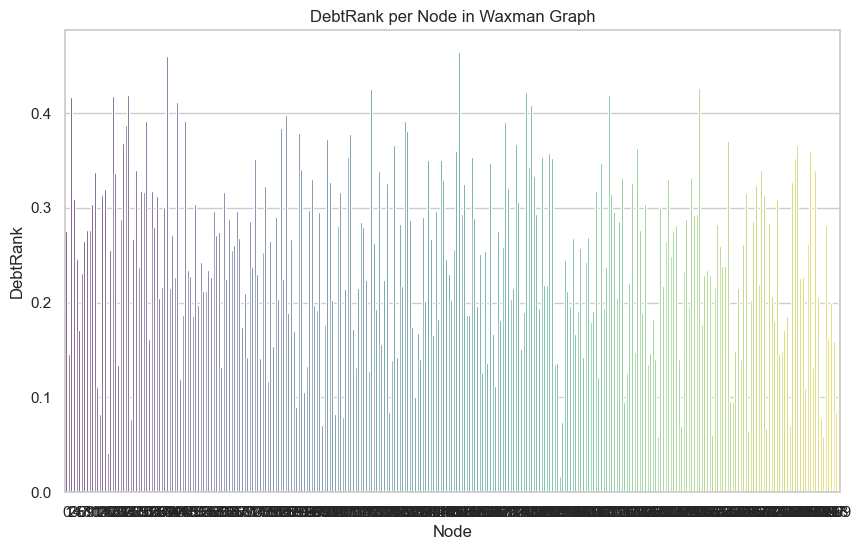

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot DebtRank values for each node in a graph
def plot_debt_rank_per_node(df, graph_name):
    df_graph = df[df['graph'] == graph_name]
    plt.figure(figsize=(10, 6))
    sns.barplot(x='node', y='DebtRank', data=df_graph, palette='viridis')
    plt.xlabel('Node')
    plt.ylabel('DebtRank')
    plt.title(f'DebtRank per Node in {graph_name.replace("_", " ").title()} Graph')
    plt.show()

# Plot for each graph
for graph_name in graphs.keys():
    plot_debt_rank_per_node(df_debt_rank, graph_name)


In [143]:
gr = graphs['barabasi_albert']

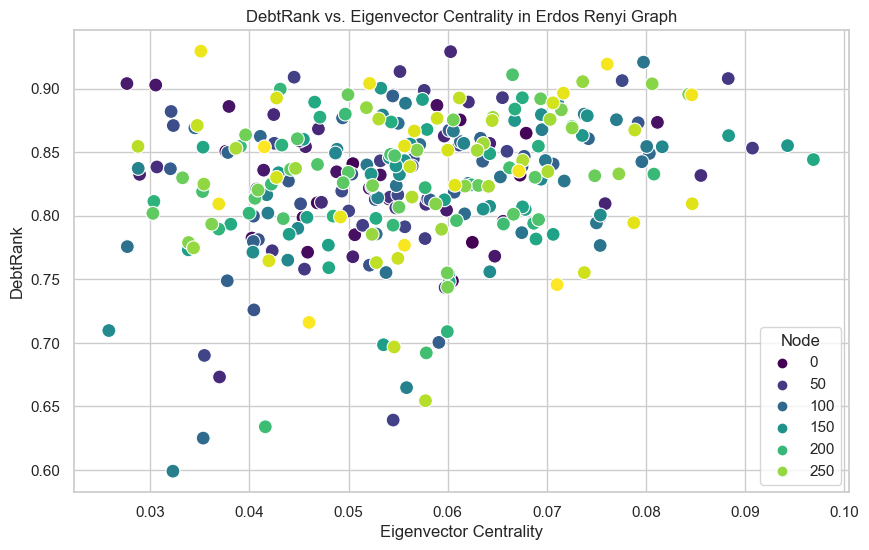

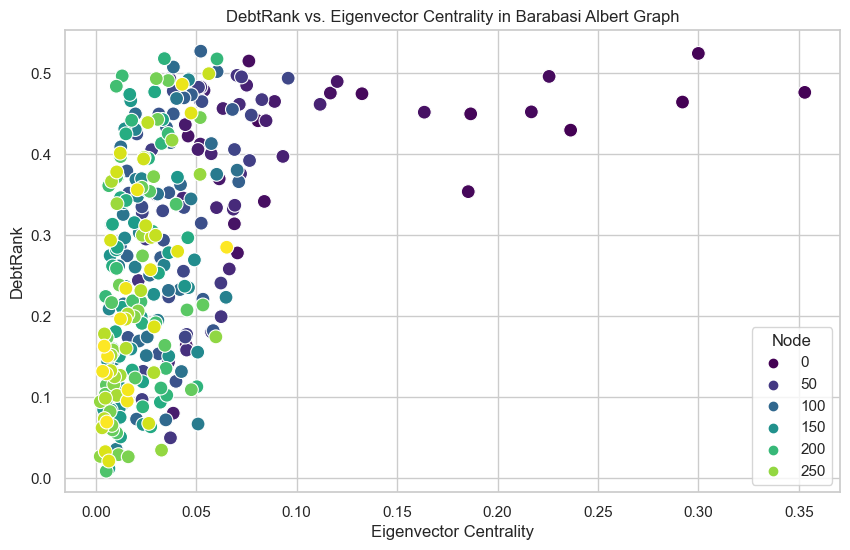

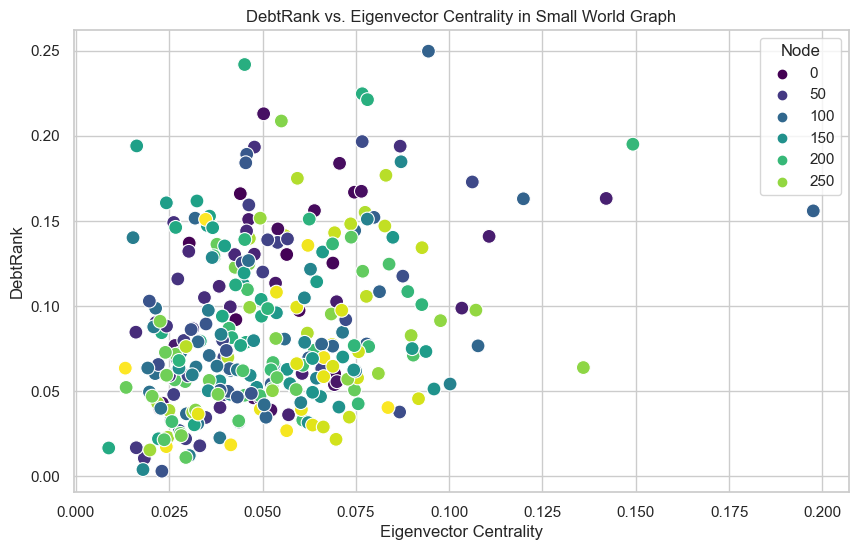

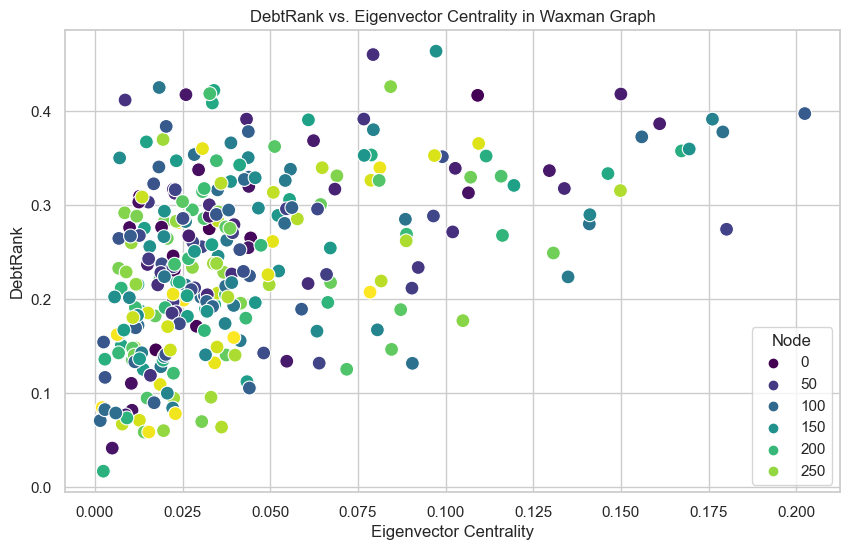

In [144]:
# Debtrank vs centrality measures

# Function to plot DebtRank vs. Centrality Measures
def plot_debt_rank_vs_centrality(df, graph_name, centrality_measure):
    df_graph = df[df['graph'] == graph_name]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=centrality_measure, y='DebtRank', data=df_graph, hue='node', palette='viridis', s=100)
    plt.xlabel(centrality_measure.replace('_', ' ').title())
    plt.ylabel('DebtRank')
    plt.title(f'DebtRank vs. {centrality_measure.replace("_", " ").title()} in {graph_name.replace("_", " ").title()} Graph')
    plt.legend(title='Node')
    plt.show()

# Plot DebtRank vs. Degree Centrality
for graph_name in graphs.keys():
    plot_debt_rank_vs_centrality(df_debt_rank, graph_name, 'eigenvector_centrality')


In [145]:
df_ba = df_debt_rank[df_debt_rank['graph'] == 'barabasi_albert']

In [146]:
df_ba.sort_values(by='v_j', ascending=False)

,graph,node,DebtRank,time_steps,v_j,degree_centrality,betweenness_centrality,eigenvector_centrality,closeness_centrality,cap_buffer
303,barabasi_albert,3,0.524195,6,0.025159,0.187291,0.154428,0.299951,0.390850,504.406078
302,barabasi_albert,2,0.476145,6,0.020548,0.160535,0.184921,0.352930,0.421721,15.357783
306,barabasi_albert,6,0.452071,6,0.019853,0.187291,0.143778,0.216809,0.370508,118.018763
301,barabasi_albert,1,0.429561,6,0.018401,0.147157,0.121319,0.236364,0.389831,585.453200
309,barabasi_albert,9,0.495829,6,0.017955,0.153846,0.088370,0.225638,0.356802,84.322406
...,...,...,...,...,...,...,...,...,...,...
563,barabasi_albert,263,0.130428,7,0.000508,0.013378,0.000876,0.028887,0.283681,25.261892
452,barabasi_albert,152,0.354567,8,0.000404,0.013378,0.000000,0.025922,0.262973,550.433724
523,barabasi_albert,223,0.123739,7,0.000257,0.013378,0.000000,0.019543,0.265071,53.797704
598,barabasi_albert,298,0.285061,6,0.000166,0.013378,0.002853,0.065130,0.312435,588.765176


In [147]:
df_debt_rank[df_debt_rank['graph'] == 'barabasi_albert']

,graph,node,DebtRank,time_steps,v_j,degree_centrality,betweenness_centrality,eigenvector_centrality,closeness_centrality,cap_buffer
300,barabasi_albert,0,0.464207,6,0.017752,0.153846,0.121088,0.292056,0.390850,41.525962
301,barabasi_albert,1,0.429561,6,0.018401,0.147157,0.121319,0.236364,0.389831,585.453200
302,barabasi_albert,2,0.476145,6,0.020548,0.160535,0.184921,0.352930,0.421721,15.357783
303,barabasi_albert,3,0.524195,6,0.025159,0.187291,0.154428,0.299951,0.390850,504.406078
304,barabasi_albert,4,0.449628,6,0.013828,0.120401,0.089695,0.186605,0.371891,432.498305
...,...,...,...,...,...,...,...,...,...,...
595,barabasi_albert,295,0.132004,8,0.003071,0.013378,0.000659,0.003378,0.220015,50.215336
596,barabasi_albert,296,0.150748,8,0.001760,0.013378,0.000878,0.005810,0.229823,497.243976
597,barabasi_albert,297,0.069420,8,0.002669,0.013378,0.000250,0.005406,0.225320,151.399642
598,barabasi_albert,298,0.285061,6,0.000166,0.013378,0.002853,0.065130,0.312435,588.765176
